# A study in regression

The goal is put to use the statistical methods learnt in ISLP/ESL. We propose to try to analyse a data set from the scikit-learn package. It concerns house prices in California. Eight quantitative predictors are present. The target is median price of a house in hundreds of thousands of dollars. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import (LinearRegression, GammaRegressor, TweedieRegressor)
import sklearn.feature_selection as sklfs
import sklearn.model_selection as sklms
import sklearn.pipeline as sklpl
import sklearn.preprocessing as sklpp
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import (DecisionTreeClassifier,
                          DecisionTreeRegressor)
from sklearn.metrics import (accuracy_score, log_loss)
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor)

import statsmodels.api as sm
from statsmodels.stats.outliers_influence \
     import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

from ISLP.models import (ModelSpec, summarize, poly)
from ISLP.models import (Stepwise, sklearn_selected, sklearn_selection_path)

We begin by loading, and simply looking at the data, since there are "only" eight predictors. 

In [2]:
info_and_data = fetch_california_housing()
X_idx = info_and_data['feature_names']
print(info_and_data['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [3]:
X, y = info_and_data['data'], info_and_data['target']

In [4]:
X_df, y_df = pd.DataFrame(X), pd.DataFrame(y)
columns_names_dict = dict(zip(range(8), X_idx))
X_df = X_df.rename(columns_names_dict, axis = 1)
y_df = y_df.rename({0: 'MedValue'}, axis = 1)

In [5]:
#pd.plotting.scatter_matrix(X_df, figsize = (10, 8))

Looking at the matrix of plots above, we notice probable outliers in the `AveOccup` -- average number of household members -- entries. Indeed, using the lines that follow, we find that the maximum for AveOccup is $1243$, which seems fishy. In seven of the rows of our DataFrame of observations, AveOccup is superior to $50$. 

In [6]:
print('Maximum value for AveOccup:') 
print(X_df['AveOccup'].max())
print('Number of instances of values for AveOccup higher than 50: ')
np.array([X_df['AveOccup'] >= 50]).sum()

Maximum value for AveOccup:
1243.3333333333333
Number of instances of values for AveOccup higher than 50: 


7

We decide to remove these rows from the dataset. This is done with the few lines of codes below. A new matrix of plots does not reveal any suspicious entries in the predictors, at least after a quick glance. 

In [7]:
X_df_clean = X_df.drop(np.where([X_df['AveOccup'] >= 50])[1])
y_df_clean = y_df.drop(np.where([X_df['AveOccup'] >= 50])[1])
X_df, y_df = X_df_clean, y_df_clean
X_df.index, y_df.index = range(len(X_df)), range(len(y_df))
#pd.plotting.scatter_matrix(X_df, figsize = (10, 8))

Plotting a histogram of the response, however, shows an interesting phenomenon. 

(array([   9.,   14.,   61.,  255.,  538.,  675.,  546.,  803.,  881.,
         706.,  812.,  715.,  835.,  815.,  920.,  958.,  786.,  817.,
         703.,  505.,  620.,  660.,  578.,  508.,  432.,  439.,  463.,
         331.,  320.,  216.,  224.,  232.,  245.,  252.,  285.,  193.,
         160.,  149.,  117.,  133.,  104.,   99.,   80.,   90.,  106.,
          66.,   49.,   51.,   47., 1030.]),
 array([0.14999  , 0.2469904, 0.3439908, 0.4409912, 0.5379916, 0.634992 ,
        0.7319924, 0.8289928, 0.9259932, 1.0229936, 1.119994 , 1.2169944,
        1.3139948, 1.4109952, 1.5079956, 1.604996 , 1.7019964, 1.7989968,
        1.8959972, 1.9929976, 2.089998 , 2.1869984, 2.2839988, 2.3809992,
        2.4779996, 2.575    , 2.6720004, 2.7690008, 2.8660012, 2.9630016,
        3.060002 , 3.1570024, 3.2540028, 3.3510032, 3.4480036, 3.545004 ,
        3.6420044, 3.7390048, 3.8360052, 3.9330056, 4.030006 , 4.1270064,
        4.2240068, 4.3210072, 4.4180076, 4.515008 , 4.6120084, 4.7090088,
        

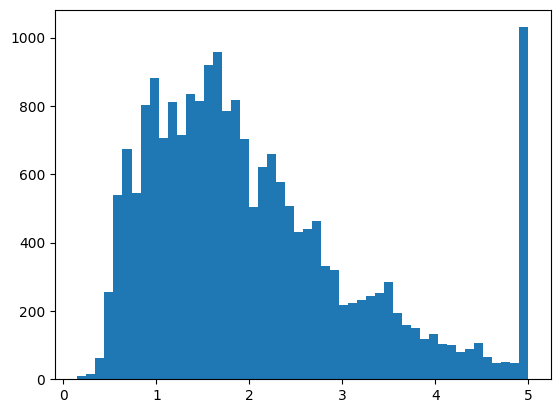

In [8]:
plt.hist(np.array(y_df), bins = 50)

It seems as if the data has been altered by a cut-off procedure. More precisely, it looks exactly as if any house whose price exceeded $5$ (hundreds of dollars) had been entered as costing $500 000$ dollars. A quick search on scikit-learn's documentation for the `fetch_california_housing()` function confirms this suspicion. This is pretty bad news. Unfortunately, we have to discard this part of the data as well. We can keep the concerned entries for testing though: once a model is conceived and fit on the rest of the data, we can assess it by measuring which fraction of these "most expensive houses" the model evaluates at more than $500 000$ dollars. The closer this metric to $1$, the better. 

(array([  9.,  14.,  61., 255., 538., 665., 545., 802., 891., 703., 810.,
        698., 848., 813., 910., 964., 780., 826., 700., 507., 615., 664.,
        569., 514., 433., 436., 469., 322., 327., 220., 220., 222., 254.,
        252., 288., 197., 162., 149., 116., 131., 103., 103.,  80.,  93.,
        101.,  74.,  48.,  53.,  45.,  42.]),
 array([0.14999  , 0.2468102, 0.3436304, 0.4404506, 0.5372708, 0.634091 ,
        0.7309112, 0.8277314, 0.9245516, 1.0213718, 1.118192 , 1.2150122,
        1.3118324, 1.4086526, 1.5054728, 1.602293 , 1.6991132, 1.7959334,
        1.8927536, 1.9895738, 2.086394 , 2.1832142, 2.2800344, 2.3768546,
        2.4736748, 2.570495 , 2.6673152, 2.7641354, 2.8609556, 2.9577758,
        3.054596 , 3.1514162, 3.2482364, 3.3450566, 3.4418768, 3.538697 ,
        3.6355172, 3.7323374, 3.8291576, 3.9259778, 4.022798 , 4.1196182,
        4.2164384, 4.3132586, 4.4100788, 4.506899 , 4.6037192, 4.7005394,
        4.7973596, 4.8941798, 4.991    ]),
 <BarContainer object o

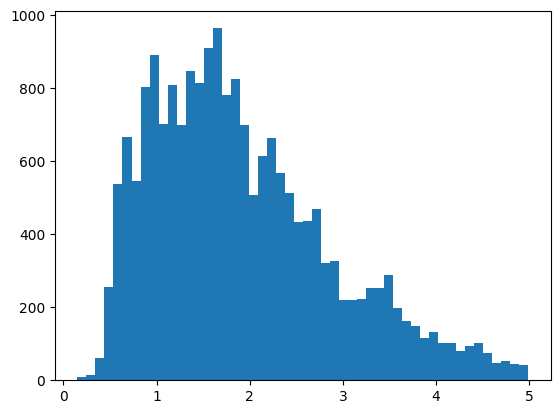

In [9]:
expensive_df = X_df.drop(np.where([y_df['MedValue'] < 5.0])[1])
expensive_df.index = range(len(expensive_df))
X_df_clean = X_df.drop(np.where([y_df['MedValue'] >= 5.0])[1])
y_df_clean = y_df.drop(np.where([y_df['MedValue'] >= 5.0])[1])
X_df, y_df = X_df_clean, y_df_clean
X_df.index, y_df.index = range(len(X_df)), range(len(y_df))
plt.hist(np.array(y_df), bins = 50)

This operation made us discard quite a chunk of the original data. That seems unavoidable, for the cut-off that had been applied would completely spoil the predicting power of a regression algorithm. 

## Linear model

Wit fit a linear with all the predictors to get a first glimpse. 

In [10]:
model = LinearRegression()
model.fit(X_df, y_df)
predictions = model.predict(X_df)

We define a function that uses matplotlib tools to produce two side-by-side plots to visulize the predictions of a model. The left graph is a scatter plot of the predicted values on the training set vs. the real, observed values. This plot should ideally be very close to a diagonal line. The right plot shows the residuals vs. the predicted values. This one is useful to try to detect some pattern in the residuals, which could hint at a particular relationship between the target and the predictors. 

In [11]:
def plot_pred_res(predictions, y, size = .5): 
    pred_tmp = predictions
    if len(predictions.shape) > 1:
        pred_tmp = predictions[:, 0]
    residuals = np.array(y['MedValue']) - pred_tmp
    fig, ax = plt.subplots(1, 2, figsize = (8, 4))
    ax[0].set_xlabel('MedValue')
    ax[0].set_ylabel('Predictions')
    ax[0].scatter(y, pred_tmp, s = size)
    ax[0].plot([y['MedValue'].min(), y['MedValue'].max()], [y['MedValue'].min(), y['MedValue'].max()], color = 'red', linestyle = '--')
    ax[1].set_xlabel('Predictions')
    ax[1].set_ylabel('Residuals')
    ax[1].scatter(pred_tmp, residuals, s = size)
    ax[1].plot([predictions.min(), predictions.max()], residuals.mean().mean()*np.ones(2), color = 'red', linestyle = '--')
    return fig, ax

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: xlabel='MedValue', ylabel='Predictions'>,
        <Axes: xlabel='Predictions', ylabel='Residuals'>], dtype=object))

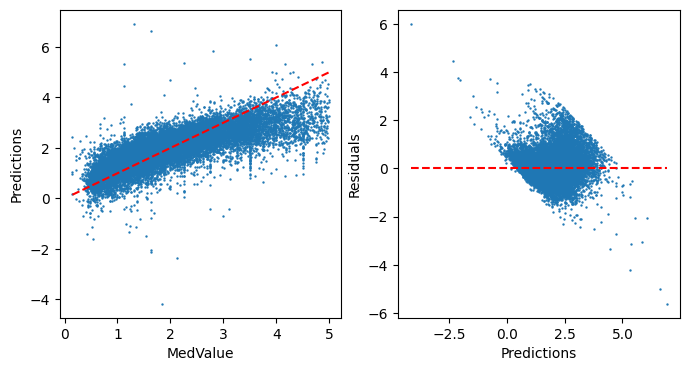

In [12]:
plot_pred_res(model.predict(X_df), y_df)

The model assessment tools displayed here (MSE, squared residuals) are unsatisfactory. We would like to compute $p$-values to evaluate the significance of the predictors. Out of the box, the scikit-learn package does not allow for quick display of the $p$-values. Thus we use two methods. Both consist in performing the usual $t$-tests associated to the predictors in the model. Computing the $t$-statistics necessary for these $t$-tests involves estimating the standard error of the coefficients beta of the model. The first method consists in estimating this standard error via bootstrapping. The second involves a more classical formula involving the MSE and the diagonal values of the big matrix $X^TX$ involved in fitting the model. The second calculation will be performed automatically by the statsmodel package. The first method we implement now.  

In [13]:
# This function estimates the variance of an estimator func, using data from a DataFrame df. 
# The function func is assumed to take as input a DataFrame. 

def boot_var(func, df, n=None, B=1000, seed=0):
    rng = np.random.default_rng(seed)
    first_, second_ = 0, 0
    n = n or df.shape[0]
    for _ in range(B):
        idx = rng.choice(df.index, n, replace=True)
        value = func(df.loc[idx])
        first_ += value
        second_ += value**2
    return second_ / B - (first_ / B)**2

In [14]:
# This function returns the (array of) parameters beta (without the intercept, eventhough an intercept is included in the model) 
# of the linear model fit with the given features and target. 
# The features and target are assumed to be given in a single data frame, in which the column of targets is simply called 'y'. 

def linear_parameters(features_and_target): 
    tmp_model = LinearRegression()
    tmp_features_idx = features_and_target.columns.drop(['y'])
    tmp_model.fit(features_and_target[tmp_features_idx], features_and_target[['y']])
    #print(tmp_model.coef_, tmp_model.intercept_)
    return tmp_model.coef_

In [15]:
# These two lines manipulate the DataFrames to produce one that has the right format to be fed to the two functions above. 
X_and_y_df = pd.concat([X_df, y_df], axis = 1)
X_and_y_df = X_and_y_df.rename({'MedValue': 'y'}, axis = 1)

B = 1000
se_beta_ = np.sqrt(boot_var(linear_parameters, X_and_y_df, B = B))
se_beta_.round(3)

array([[0.009, 0.   , 0.012, 0.08 , 0.   , 0.017, 0.008, 0.008]])

An estimation of the variance (of the standard error, really) of each of the parameters is all we needed to perform statistic tests. Under the assumption that bootstrapping yields usable samples, our estimator for the variance of the coefficients beta equals the usual sample variance estimator (aka maximum likelihood estimator). Thus the statistics $\beta_i/se(\beta_i)$ really will follow -- under the null hypotheses $\beta_i = 0$ -- Student's $t$ distribution, with as many degrees of freedom as there were folds in the bootstrap ($B$). 

In [16]:
# We compute a vector of t-statistics, and convert it to p-values. 
# The method sf stands for survival function, and evalutates P(X > t). 
# The factor 2 means to account for a two-tailed test, P(|X| > t). 
t = model.coef_/se_beta_
2*scipy.stats.t.sf(abs(t), B).round(3)

array([[0., 0., 0., 0., 0., 0., 0., 0.]])

We compare our results with the statsmodels package's calculation. 

In [17]:
design = ModelSpec(X_df).fit_transform(X_df)
results = sm.OLS(y_df, design).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               MedValue   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     3805.
Date:                Fri, 07 Feb 2025   Prob (F-statistic):               0.00
Time:                        18:41:18   Log-Likelihood:                -18099.
No. Observations:               19641   AIC:                         3.622e+04
Df Residuals:                   19632   BIC:                         3.629e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -32.1819      0.573    -56.172      0.000     -33.305     -31.059
MedInc         0.4129      0.004     92.870      0.000       0.404       0.422
HouseAge       0.0089      0.000     22.655      0.000       0.008       0.010
AveRooms      -0.0892      0.005    -16.331      0.000      -0.100      -0.078
AveBedrms      0.5018      0.025     19.922      0.000       0.452       0.551
Population  3.172e-05   4.11e-06      7.723      0.000    2.37e-05    3.98e-05
AveOccup      -0.2055      0.005    -41.403      0.000      -0.215      -0.196
Latitude      -0.3875      0.006    -61.802      0.000      -0.400      -0.375
Longitude     -0.3901      0.007    -59.493      0.000      -0.403      -0.377
==============================================================================
Omnibus:                     3974.499   Durbin-Watson:                   0.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14690.171
Skew:                           0.985   Prob(JB):                         0.00
Kurtosis:                       6.751   Cond. No.                     2.43e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We find that the two calculations for the $p$-values yield very close results, and that all the predictors seems to be relevant at first glance. This suggests that there is no evident manual feature selection to be performed to try to improve our model. However, we can still come up with suggestions.

The first is try some automated feature selection procedure, for the sake of experimentation. 

The second is to use the Latitude and Longitude predictors in a transformed way. In the matrix of plots from above, plotting Latitude against Longitude of course results in... a map of California. We have all reasons to suspect that the relationship between the response and Latitude and between the response and Longitude is strong, but not linear in the two variables. Maybe these values should be used to compute the distance to the closest major city? Or what that major city is (a qualitative predictor)? 

The third is to try some other regression techniques. 

## Feature selection in the linear model

We implement forward stepwise selection to the set of predictors. We will want to measure the cross-validated MSE of many models to compare them, so we start with functions that do just that. 

Sklearn already has a function that applies cross-validation to compute any score one may want to estimate via cross-validation. We still a function that pretty much reproduces that, for the one readily available in sklearn cannot be directly applied to the paths of models returns by `sklearn_selection_path()`. The latter comes from the ISLP packages which provides many wrappers that help manipulate statsmodels and sklearn together. In the present situation, `sklearn_selection_path()` will help get the complete path of models that is produced when performing forward selection. As mentioned above, it is impossible to call `cross_val_score()` from sklearn on the path returned by `sklearn_selection_path()`. However, it is possible to pass it to `cross_val_predict()`. The latter is an sklearn function that return cross-validated predictions from an estimator. By cross-validated predictions, we understand a collection of predictions, each belonging to a cross-validation fold that was not used to train the model it was made with. 

In [18]:
def MSE(estimator, X, y): #
    #The estimator is an sklearn estimator. It is assumed to be already fit. 
    #y is assumed to be a DataFrame with a single column: the observed response. 
    #The if blocks are only here to adapt to the many possible formats for estimator.predict(X). 
    yhat = estimator.predict(X)
    if len(yhat.shape) == 1: 
        return ((np.array(y[y.columns[0]]) - yhat)**2).mean(0)
    if yhat.shape[1] != 1:
        return (([value*np.ones(yhat.shape[1]) for value in np.array(y[y.columns[0]])] - yhat)**2).mean(0)
    return ((np.array(y[y.columns[0]]) - yhat[:, 0])**2).mean(0)

In [19]:
def MSE_CV(estimator, X, y): 
    #The estimator is an sklearn estimator. It is assumed to be already fit. 
    #y is assumed to be a DataFrame with a single column: the observed response. 
    K = 8
    kfold_cv = sklms.KFold(K, random_state=0, shuffle=True)
    predictions_cv = sklms.cross_val_predict(estimator, X, y, cv=kfold_cv) 
    MSE_cv = []
    for train_idx, test_idx in kfold_cv.split(y):
        MSE_values = ((np.array(y_df[y.columns[0]])[test_idx, None] - predictions_cv[test_idx])**2).mean(0)
        MSE_cv.append(MSE_values) # column means
    return np.array(MSE_cv)

In [20]:
K = 8
kfold_cv = sklms.KFold(K, random_state=0, shuffle=True)

Sklearn has a forward selection transformer built in. It takes many arguments whose effects should be checked in the documentation. One has to specify a target number of features. We temporarily assume we want to discard two and keep six. Once fit to the data, the transformer has a `transform()` method that deletes the unselected predictors from data. The attribute `support_` returns a mask revealing the kept/discarded variables. Applying the `transform()` method to data given in the form of a DataFrame will result in an array. It can be converted back to a DataFrame but will have lost its metadata. At each selection step, the models are assessed using a scoring function evaluated by cross-validation. The scoring function in question and the specifics of the cross-validation method -- e.g, number of folds -- can tuned by passing arguments. By default, five folds are performed on the default scorer of the passed model ($R^2$ for `LinearRegression()`). 

In [21]:
model = LinearRegression()
fwd_sel_trans = sklfs.SequentialFeatureSelector(model, n_features_to_select=6, direction='forward', scoring=None, cv=10)
fwd_sel_trans.fit(X_df, y_df)
print(X_df.columns[fwd_sel_trans.support_])

Index(['MedInc', 'HouseAge', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude'], dtype='object')


We want to compare the cross-validated MSE of this regression algorithm (this algorithm = linear regression on six predictors selected by forward selection). The cross-validation procedure should reproduce the forward selection of six variables during each fold. Thus we integrate this transformer in an sklearn pipeline. 

In [22]:
lin_model = LinearRegression()
pipe_fwd = sklpl.Pipeline(steps=[('fwd_sel', fwd_sel_trans), ('lin', lin_model)])
MSE_fwd_cv = sklms.cross_val_score(pipe_fwd, X_df, y_df, scoring = MSE, cv=kfold_cv)
MSE_fwd_cv.mean()

0.4013236167691444

We compare it to the cross-validated MSE of the full linear model. 

In [23]:
MSE_cv = sklms.cross_val_score(model, X_df, y_df, scoring = MSE, cv=kfold_cv)
MSE_cv.mean()

0.3718665491025447

<ErrorbarContainer object of 3 artists>

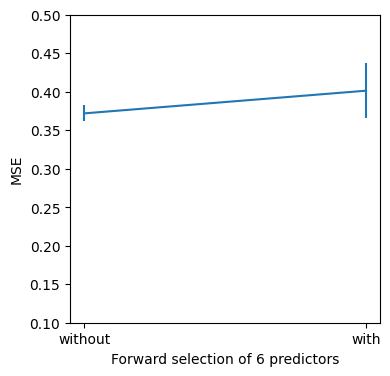

In [24]:
MSE_fig, ax = plt.subplots(figsize=(4,4))
ax.set_ylabel('MSE')
ax.set_xlabel('Forward selection of 6 predictors')
ax.set_ylim(0.1, 0.5)
ax.errorbar(['without', 'with'], 
            [MSE_cv.mean(), MSE_fwd_cv.mean()],
            [np.sqrt(MSE_cv.var()), np.sqrt(MSE_fwd_cv.var())])

We deduce it is not seem useful to make the (rather arbitrary) assumption that six out of the orignial eight predictors would perform better than all of them. If we do not know in advance which number of features we want to keep, it can be useful to keep track of the whole path of nine nested models forward selection produces. Maybe this could lead to an improvement. We use the previously advertized `sklearn_selection_path()` from the ISLP package. It forces us to again use the linear model from statsmodels, `sm.OLS`. 

In [25]:
design = ModelSpec(X_df).fit(X_df)
strategy = Stepwise.fixed_steps(design, len(design.terms), direction='forward')
full_path = sklearn_selection_path(sm.OLS, strategy)
full_path.fit(X_df, y_df)
predictions_full_path = full_path.predict(X_df)
predictions_full_path.shape

(19641, 9)

This `predictions_full_path` is an array of arrays. The $i$-th entry is the array of predictions made using the $i$-th model obtained by foward selection, relying on $i$ predictors. Below we plot the training MSE of the nince models. 

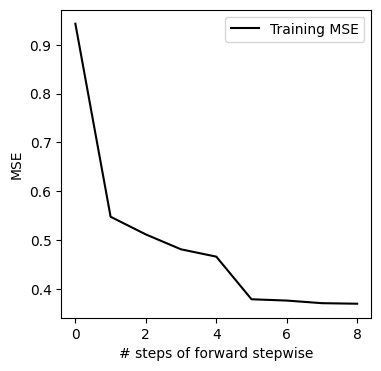

In [26]:
MSE_full_path_fig, ax = plt.subplots(figsize=(4,4))
MSE_train = MSE(full_path, X_df, y_df)

n_steps = MSE_train.shape[0]
ax.plot(np.arange(n_steps),
        MSE_train,
        c = 'k', # color black
        label = 'Training MSE')
ax.set_ylabel('MSE')
ax.set_xlabel('# steps of forward stepwise')
ax.legend();

Of course, it decreases strictly. To make a choice of model, we should estimate the test MSE by cross-validation. We would like to use the `cross_val_score()` function from sklearn, but we warned above what we got from the wrapper `sklearn_selected_path()` cannot be passed to `cross_cal_score()`. Thus we use our improvized copy function. 

In [27]:
MSE_cv = MSE_CV(full_path, X_df, y_df)
MSE_cv = np.array(MSE_cv).T
MSE_cv.shape

(9, 8)

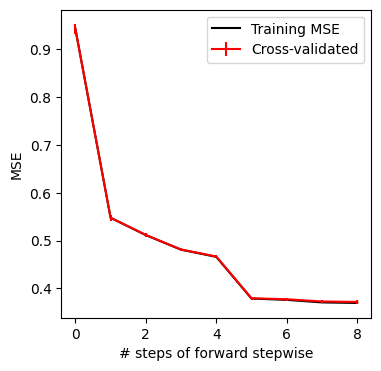

In [28]:
ax.errorbar(np.arange(n_steps), 
            MSE_cv.mean(1), 
            MSE_cv.std(1) / np.sqrt(K),
            label='Cross-validated',
            c='r') # color red
ax.legend()
MSE_full_path_fig

We find the cross-validated MSE is not much higher than the training MSE in this situation. We observe adding more than five predictors does not result in a substancial drop in test MSE. Running the lines of codes from sklearn from above, with a five in place of the previous six, we find the five predictors that have pretty much as much predicting power as the full eight are often `MecInc`, `HouseAge`, `AveOccup`, `Latitude` and `Longitude`. The red curve is not U-shaped, so the only things to gain from picking a subset of the predictors is interpretability and simplicity. 

In [29]:
model = LinearRegression()
fwd_sel_trans = sklfs.SequentialFeatureSelector(model, n_features_to_select = 5, direction='forward', scoring=None, cv = kfold_cv)
fwd_sel_trans.fit(X_df, y_df)
X_df.columns[fwd_sel_trans.support_]

Index(['MedInc', 'HouseAge', 'AveOccup', 'Latitude', 'Longitude'], dtype='object')

In [30]:
pipe_fwd = sklpl.Pipeline(steps=[('fwd_sel', fwd_sel_trans), ('lin', model)])
MSE_fwd_cv = sklms.cross_val_score(pipe_fwd, X_df, y_df, scoring = MSE, cv = kfold_cv)
MSE_fwd_cv.mean()

0.3796098887392203

We do not propose to try ridge regression, Lasso, or any kind or ElasticNet algorithm, for there are few features in the present situation. 

## Addition of non-linear terms

We mentioned above we want to treat `Latitude` and `Longiture` in a non-linear fashion. To see if there are other predictors we may want to treat in a non-linear way, we plot the response with respect to predictors individually (a luxury we have because the number of predictors is fairly small). 

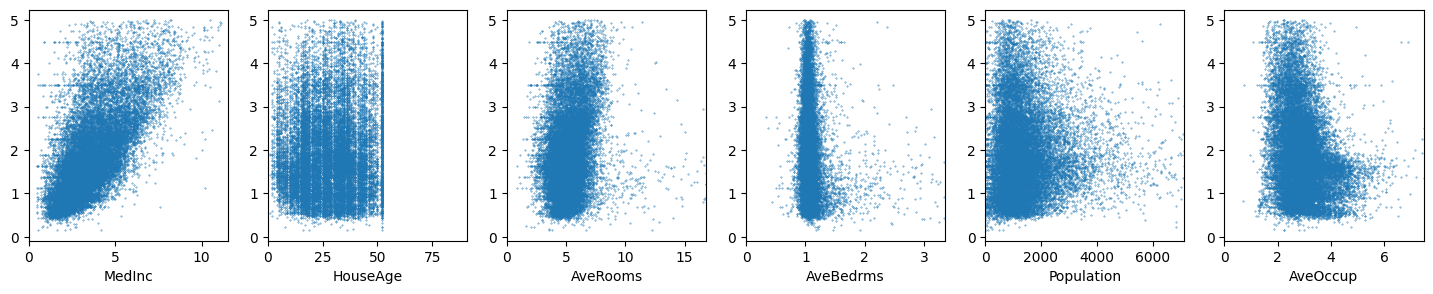

In [31]:
fig, axs = plt.subplots(1, 6, figsize = (18, 3))
for i in range(6):
    axs[i].scatter(X_df[X_df.columns[i]], y_df, s=.1)
    axs[i].set_xlabel(X_df.columns[i])
    axs[i].set_xlim([0, X_df[X_df.columns[i]].mean()+5*X_df[X_df.columns[i]].std()])
plt.savefig('California house price plots')

We get the following convictions: assuming a linear relationship between the response and MedInc, between the response and AveRooms and between the response and AveBedroms is a good choice. Due to the high variability in the other plots, it is harder to decide. Thus we choose to add non-linear terms that depends on Latitude and Longitude only. We try two approaches. The first one is to manufacture these non-linear terms ourselves, using the Latitude and Longitude of each observation to determine the distances to the most expensive cities in California. The second approach is to use a generalized additive model (GAM) with an intercept, a linear term for each of the six first predictors, and a term depending on Latitude and Longitude that should be fit by local regression, or via a 2d smoothing spline. It seems as if choosing a 2d smoothing spline would be easier, for the whole model would then boil down to an instance of the basis function method. This second approach we will probably work on later. 

### Distance to expensive cities

We begin by collecting the nine most expensive cities in California. They are Los Angeles, Santa Barbara, Santa Rosa, San Diego, San Francisco, Salinas, Vallejo, San Jose and Sacramento. We collect their coordinates in a dictionary and define a function that calculates the distance to each city. 

In [32]:
cities = {'Los_Angeles': [34.05, -118.24], 
         'Santa_Barbara': [34.42, -119.67], 
         'Santa_Rosa': [38.44, -122.72], 
         'San_Diego': [32.71, -117.16],
         'San_Francisco': [37.77, -122.43], 
         'Salinas': [36.677, -121.65], 
         'Vallejo': [38.10, -122.25], 
         'San_Jose': [37.33, -121.89], 
         'Sacramento': [38.57, -121.47]}

def dist_to_city(lat, long, city): 
    return np.sqrt((cities[city][0]-lat)**2 + (cities[city][1]-long)**2)

Next step is to define our own scikit-learn transformer. Its `fit()` method should not do anything. However, its `transform()` method should remove the `Latitude` and `Longitude` column of a DataFrame, and replace them with nine new columns, filled with values depending on the distances to each of the cities in the dictionary. The dictionary of cities should be passed to the transformer as a parameter when summoning an instance of it. We include another parameter, power, which is involved in the way we transform the distances. It will be an attribute that can be used in, e.g, the `transform()` method. 

In [33]:
class DistanceToCities(BaseEstimator, TransformerMixin):
    def __init__(self, cities=[], power = 2):
        self.power = power
        self.cities = cities
        
    def fit(self, X=None, y=None):
        return self

    def transform(self, X, y=None): #X is assumed to be a DataFrame in which a column 'Latitude' and a column 'Longitude' can be found. 
        new_X = X.copy()
        N = len(new_X)
        for city in self.cities: 
            new_column_name = 'DistFrom' + city
            new_column = np.exp(-(dist_to_city(new_X['Latitude'], new_X['Longitude'], city)**self.power))
            new_X[new_column_name] = new_column
        new_X = new_X.drop(['Latitude', 'Longitude'], axis = 1)
        return new_X

In [34]:
dist_trans = DistanceToCities(cities, power = 2)
lin_model = LinearRegression()
pipe_dist = sklpl.Pipeline(steps=[('calculate_dist', dist_trans), ('lin', lin_model)])
pipe_dist.fit(X_df, y_df)
MSE_dists_train = MSE(pipe_dist, X_df, y_df)
MSE_dists_train

0.32431530468136854

This quick computation of the training MSE suggest we improved the model over the one that used `Longitude` and `Latitude`. We compute a cross-validated MSE to be assured of that. 

In [35]:
MSE_dist_cv = sklms.cross_val_score(pipe_dist, X_df, y_df, scoring = MSE, cv = kfold_cv)
MSE_dist_cv.mean()

0.32575213638570955

We are conforted in our belief. 

The `DistanceToCities` transformers produces many variables for the linear model that follows it. Thus it could be wise to try some feature selection again. We reproduce it. 

In [36]:
X_dist = dist_trans.transform(X_df)
design = ModelSpec(X_dist).fit(X_dist)
strategy = Stepwise.fixed_steps(design, len(design.terms), direction='forward')
full_path_dist = sklearn_selection_path(sm.OLS, strategy)
full_path_dist.fit(dist_trans.transform(X_df), y_df)
MSE_dist_train = MSE(full_path_dist, dist_trans.transform(X_df), y_df)
MSE_dist_cv = np.array(MSE_CV(full_path_dist, dist_trans.transform(X_df), y_df)).T

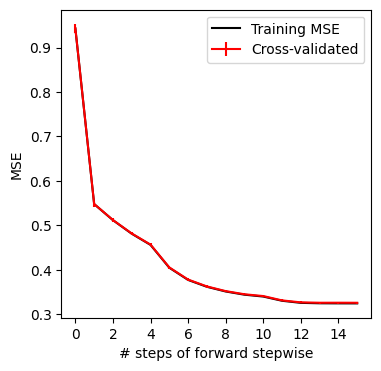

In [37]:
MSE_full_path_fig_dist, ax = plt.subplots(figsize=(4,4))
ax.set_ylabel('MSE')
ax.set_xlabel('# steps of forward stepwise')
n_steps = MSE_dist_train.shape[0]
ax.set_xticks(np.arange(n_steps)[::2])
ax.plot(np.arange(n_steps),
        MSE_dist_train,
        c='k', # color black
        label='Training MSE')
ax.errorbar(np.arange(n_steps), 
            MSE_dist_cv.mean(1),
            MSE_dist_cv.std(1) / np.sqrt(K),
            label='Cross-validated',
            c='r') # color red
ax.legend()

Again, the red curve is not U-shaped, so there is no gain in MSE to be made by picking a good subset of the many predictors. However, there is no gain either in choosing all of them over a certain subset of eleven. Reading the output of the few lines of code below, we see our `DistFrom***` entries are well-represented. 

In [38]:
model = LinearRegression()
lin_model = LinearRegression()
fwd_sel_trans_11 = sklfs.SequentialFeatureSelector(model, n_features_to_select=11, direction='forward', scoring = None, cv = kfold_cv)
pipe_dist_fwd = sklpl.Pipeline(steps=[('calculate_dist', dist_trans), ('fwd_sel', fwd_sel_trans_11), ('lin', lin_model)])
pipe_dist_fwd.fit(X_df, y_df)
pipe_dist_fwd['fwd_sel'].get_feature_names_out()

array(['MedInc', 'HouseAge', 'AveOccup', 'DistFromLos_Angeles',
       'DistFromSanta_Barbara', 'DistFromSan_Diego',
       'DistFromSan_Francisco', 'DistFromSalinas', 'DistFromVallejo',
       'DistFromSan_Jose', 'DistFromSacramento'], dtype=object)

Below are some plots and statistics of the final model. The $R^2$ equals $0.65$. The fraction of expensive houses whose price is predicted to be superior to $500 000$ dollars is $12\%$... very low. 

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: xlabel='MedValue', ylabel='Predictions'>,
        <Axes: xlabel='Predictions', ylabel='Residuals'>], dtype=object))

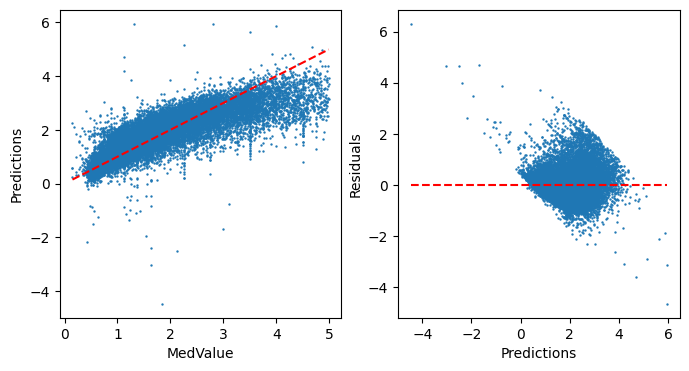

In [39]:
dist_fwd_predictions = pipe_dist_fwd.predict(X_df)
plot_pred_res(dist_fwd_predictions, y_df)

In [40]:
pipe_dist_fwd.score(X_df, y_df) #R² 

0.6498368654407828

In [41]:
expensive_predictions = pipe_dist_fwd.predict(expensive_df)[:, 0]
(expensive_predictions >= 5).sum()/len(expensive_predictions)

0.11693548387096774

## Gamma Regression

We try to fit a generalized linear model (GLM) with assumed Gamma distribution. Motivation: the response is a price, something we model as continuous and non-negative. After a few attemps, it seems clear it is unlikely to perform better than the linear regression above. Although, it is better at detecting the most expensive houses. 

In [42]:
gamma_glm = TweedieRegressor(power = 2, link = 'log', alpha = 0) #GLM with Gamma distribution and no L²-penalty (alpha = 0). 
std_scaler = sklpp.StandardScaler(copy=True, with_mean=True, with_std=True)
pipe_gamma = sklpl.Pipeline(steps=[('calculate_dist', dist_trans), ('std', std_scaler), ('glm', gamma_glm)])
pipe_gamma.fit(X_df, y_df)

/home/etienne/python_virtual_env/python_science/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('calculate_dist',
                 DistanceToCities(cities={'Los_Angeles': [34.05, -118.24],
                                          'Sacramento': [38.57, -121.47],
                                          'Salinas': [36.677, -121.65],
                                          'San_Diego': [32.71, -117.16],
                                          'San_Francisco': [37.77, -122.43],
                                          'San_Jose': [37.33, -121.89],
                                          'Santa_Barbara': [34.42, -119.67],
                                          'Santa_Rosa': [38.44, -122.72],
                                          'Vallejo': [38.1, -122.25]})),
                ('std', StandardScaler()),
                ('glm', TweedieRegressor(alpha=0, link='log', power=2))])

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: xlabel='MedValue', ylabel='Predictions'>,
        <Axes: xlabel='Predictions', ylabel='Residuals'>], dtype=object))

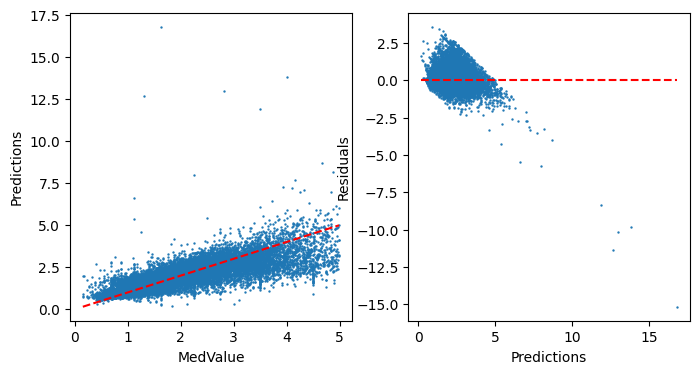

In [43]:
gamma_predictions = pipe_gamma.predict(X_df)
plot_pred_res(gamma_predictions, y_df)

In [44]:
MSE_gamma_cv = sklms.cross_val_score(pipe_gamma, X_df, y_df, scoring = MSE, cv = kfold_cv)
X_trans = dist_trans.transform(X_df)
X_trans = std_scaler.transform(X_trans)

D2 = pipe_gamma['glm'].score(X_trans, np.array(y_df[y_df.columns[0]])) #D² 
print('Training MSE, cross-validated MSE and D²: ')
MSE(pipe_gamma, X_df, y_df).mean(), MSE_gamma_cv.mean(), D2

/home/etienne/python_virtual_env/python_science/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/etienne/python_virtual_env/python_science/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/etienne/python_virtual_env/python_science/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/etienne/python_virtual_env/python_science/lib/python3.12/site-packages/sklearn/utils/validatio

Training MSE, cross-validated MSE and D²: 


(0.35585335859377054, 0.3670716648723172, 0.6754476726596226)

In [45]:
expensive_predictions = pipe_gamma.predict(expensive_df)
print('Fraction of expensive houses predicted as such: ')
(expensive_predictions >= 5).sum()/len(expensive_predictions)

Fraction of expensive houses predicted as such: 


0.38810483870967744

## Bagged trees and random forests

We give bagged decision trees and radom forests a go. The first is realized as a special case of the second, with the number of splitting predictors $m$ equal to the total number $p$ of predictors. Folklore tends to preach: "bagging for regression, random forests with $m \simeq \sqrt(p)$ for classifications". 

In [46]:
m = X_df.shape[1] + len(cities) - 2 #The number of features after DistanceToCities is applied. 
bag = RandomForestRegressor(n_estimators=150, max_features = m, max_depth=None, random_state=0)
pipe_bag = pipe_gamma = sklpl.Pipeline(steps=[('calculate_dist', dist_trans), ('bag', bag)])
pipe_bag.fit(X_df, y_df)

/home/etienne/python_virtual_env/python_science/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('calculate_dist',
                 DistanceToCities(cities={'Los_Angeles': [34.05, -118.24],
                                          'Sacramento': [38.57, -121.47],
                                          'Salinas': [36.677, -121.65],
                                          'San_Diego': [32.71, -117.16],
                                          'San_Francisco': [37.77, -122.43],
                                          'San_Jose': [37.33, -121.89],
                                          'Santa_Barbara': [34.42, -119.67],
                                          'Santa_Rosa': [38.44, -122.72],
                                          'Vallejo': [38.1, -122.25]})),
                ('bag',
                 RandomForestRegressor(max_features=15, n_estimators=150,
                                       random_state=0))])

In [47]:
feature_importances = pd.DataFrame({'importance': pipe_bag['bag'].feature_importances_})
feature_importances.index = pipe_bag['bag'].feature_names_in_
feature_importances = feature_importances.sort_values(by = 'importance', ascending = False)
feature_importances

,importance
MedInc,0.442315
AveOccup,0.123102
DistFromLos_Angeles,0.060994
DistFromSacramento,0.047824
DistFromSanta_Barbara,0.045582
DistFromSan_Francisco,0.040450
HouseAge,0.040085
DistFromSan_Jose,0.035878
AveRooms,0.031679
Population,0.027158


In [48]:
MSE_bag_cv = sklms.cross_val_score(pipe_gamma, X_df, y_df, scoring = MSE, cv = kfold_cv)
MSE_bag_cv.mean(), MSE_bag_cv.std()

/home/etienne/python_virtual_env/python_science/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/etienne/python_virtual_env/python_science/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/etienne/python_virtual_env/python_science/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/etienne/python_virtual_env/python_science/lib/python3.12/site-packages/sklearn/base.py:1

(0.19155199648146037, 0.00624174687448224)

From the table of feature importances we see the median income of the occupants is still the variable with the most deciding power, far in front of the others. Some of our cities do not do too bad. From the computation of the cross-validated MSE we wee the bagged trees perform way better than linear regression. We try changing the parameter $m$ next. 

In [49]:
m = int(np.sqrt(m)) #Square root of the previous m. 
RF = RandomForestRegressor(n_estimators=150, max_features = m, max_depth=None, random_state=0)
pipe_RF = pipe_gamma = sklpl.Pipeline(steps=[('calculate_dist', dist_trans), ('RF', RF)])
pipe_RF.fit(X_df, y_df)

/home/etienne/python_virtual_env/python_science/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('calculate_dist',
                 DistanceToCities(cities={'Los_Angeles': [34.05, -118.24],
                                          'Sacramento': [38.57, -121.47],
                                          'Salinas': [36.677, -121.65],
                                          'San_Diego': [32.71, -117.16],
                                          'San_Francisco': [37.77, -122.43],
                                          'San_Jose': [37.33, -121.89],
                                          'Santa_Barbara': [34.42, -119.67],
                                          'Santa_Rosa': [38.44, -122.72],
                                          'Vallejo': [38.1, -122.25]})),
                ('RF',
                 RandomForestRegressor(max_features=3, n_estimators=150,
                                       random_state=0))])

In [50]:
MSE_RF_cv = sklms.cross_val_score(pipe_RF, X_df, y_df, scoring = MSE, cv = kfold_cv)
MSE_RF_cv.mean(), MSE_RF_cv.std()

/home/etienne/python_virtual_env/python_science/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/etienne/python_virtual_env/python_science/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/etienne/python_virtual_env/python_science/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/etienne/python_virtual_env/python_science/lib/python3.12/site-packages/sklearn/base.py:1

(0.15475746559805126, 0.004656104165814028)

It appears ranfom forests with $m \simeq \sqrt p$ perform even better. Below are predictions vs reality and errors vs. predictions graphs for the random forests algorithm. 

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: xlabel='MedValue', ylabel='Predictions'>,
        <Axes: xlabel='Predictions', ylabel='Residuals'>], dtype=object))

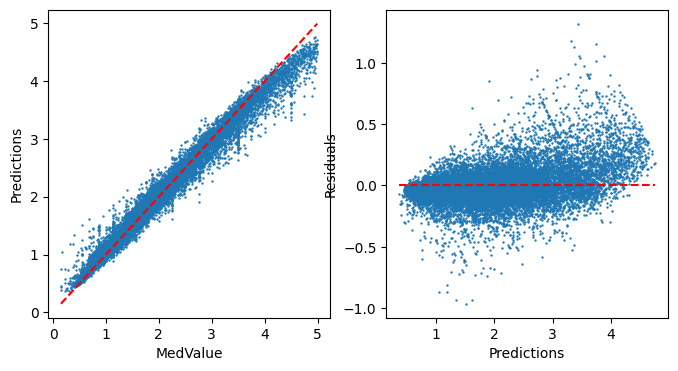

In [51]:
RF_predictions = pipe_RF.predict(X_df)
plot_pred_res(RF_predictions, y_df)

## Boosting trees

We try an algorithm with boosted trees. The performance is not particularly convincing, relative to the models above. 

In [52]:
boost = GradientBoostingRegressor(n_estimators = 3000,
                                    learning_rate = 0.001,
                                    max_depth = 3,
                                    random_state = 0)
pipe_boost = sklpl.Pipeline(steps=[('calculate_dist', dist_trans), ('boost', boost)])
pipe_boost.fit(X_df, y_df)

/home/etienne/python_virtual_env/python_science/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Pipeline(steps=[('calculate_dist',
                 DistanceToCities(cities={'Los_Angeles': [34.05, -118.24],
                                          'Sacramento': [38.57, -121.47],
                                          'Salinas': [36.677, -121.65],
                                          'San_Diego': [32.71, -117.16],
                                          'San_Francisco': [37.77, -122.43],
                                          'San_Jose': [37.33, -121.89],
                                          'Santa_Barbara': [34.42, -119.67],
                                          'Santa_Rosa': [38.44, -122.72],
                                          'Vallejo': [38.1, -122.25]})),
                ('boost',
                 GradientBoostingRegressor(learning_rate=0.001,
                                           n_estimators=3000,
                                           random_state=0))])

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: xlabel='MedValue', ylabel='Predictions'>,
        <Axes: xlabel='Predictions', ylabel='Residuals'>], dtype=object))

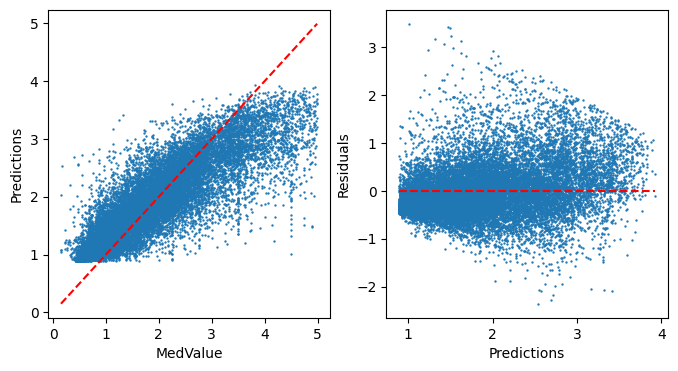

In [53]:
boost_predictions = pipe_boost.predict(X_df)
plot_pred_res(boost_predictions, y_df)

In [54]:
MSE_boost_cv = sklms.cross_val_score(pipe_boost, X_df, y_df, scoring = MSE, cv = 3)
MSE_boost_cv.mean(), MSE_boost_cv.std()

/home/etienne/python_virtual_env/python_science/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/home/etienne/python_virtual_env/python_science/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/home/etienne/python_virtual_env/python_science/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


(0.46911353202614253, 0.10451699415508353)